#British Airways review sentiment analysis using BERT model with SEMMA framework approach



In [ ]:
# Gunakan magic Colab agar paket benar‑benar ter‑install
%pip install wandb --upgrade


## 1. Sample
Tahap ini dilakukan pengumpulan sample data melalui website www.airlinequality.com

In [ ]:
# prompt: install a vader sentiment here

!pip install vaderSentiment

In [ ]:
twitter_auth_token = '4859eaae21abdcbcd2045c59596cee59972cae06'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# --------------------------------
# FUNGSI BANTUAN UNTUK MENGAMBIL NILAI DARI TABEL RATING
# --------------------------------
def get_table_value(review, header_class, value_class):
    """
    Mencari baris <tr> yang di dalamnya terdapat:
      <td class="header_class">...</td>
      <td class="value_class">...</td>
    lalu mengambil teks di <td class="value_class">.
    """
    header_el = review.find("td", class_=header_class)
    if not header_el:
        return None
    row = header_el.find_parent("tr")
    if not row:
        return None
    value_td = row.find("td", class_=value_class)
    if value_td:
        return value_td.get_text(strip=True)
    return None

def get_table_star(review, header_class, star_class):
    """
    Mencari baris <tr> yang di dalamnya terdapat:
      <td class="header_class">...</td>
      <td class="star_class"> ... <span class="star fill">X</span> ... </td>
    lalu menghitung jumlah elemen <span class="star fill"> yang ditemukan.
    """
    header_el = review.find("td", class_=header_class)
    if not header_el:
        return None

    row = header_el.find_parent("tr")
    if not row:
        return None

    star_td = row.find("td", class_=star_class)
    if star_td:
        # Cari semua span dengan class="star fill"
        fill_spans = star_td.find_all("span", class_="star fill")
        if fill_spans:
            # Mengembalikan jumlah bintang yang 'fill'
            return len(fill_spans)
    return None

# --------------------------------
# FUNGSI UTAMA UNTUK PARSING SATU REVIEW
# --------------------------------
def parse_review(review):
    data = {}

    # 1. Nama user (class="text_sub_header userStatusWrapper")
    user_name_el = review.find("h3", class_="text_sub_header userStatusWrapper")
    data["user_name"] = user_name_el.get_text(strip=True) if user_name_el else None

    # 2. Tanggal review (itemprop="datePublished")
    date_pub_el = review.find(attrs={"itemprop": "datePublished"})
    data["date_published"] = date_pub_el.get_text(strip=True) if date_pub_el else None

    # 3. Konten review (class="text_content")
    content_el = review.find("div", class_="text_content")
    data["text_content"] = content_el.get_text(strip=True) if content_el else None

    # 4. Aircraft (header + value)
    data["aircraft_value"] = get_table_value(review,
                                             "review-rating-header aircraft",
                                             "review-value")

    # 5. Type of traveller
    data["type_of_traveller_value"] = get_table_value(review,
                                                      "review-rating-header type_of_traveller",
                                                      "review-value")

    # 6. Cabin flown (seat type)
    data["cabin_flown_value"] = get_table_value(review,
                                                "review-rating-header cabin_flown",
                                                "review-value")

    # 7. Seat comfort
    #    - Teks di "review-value" (jika ada)
    data["seat_comfort_value"] = get_table_value(review,
                                                 "review-rating-header seat_comfort",
                                                 "review-value")
    #    - Rating bintang di "review-rating-stars stars"
    data["seat_comfort_star"] = get_table_star(review,
                                               "review-rating-header seat_comfort",
                                               "review-rating-stars stars")

    # 8. Date flown
    data["date_flown_value"] = get_table_value(review,
                                               "review-rating-header date_flown",
                                               "review-value")

    # 9. Cabin staff service (rating bintang)
    data["cabin_staff_service_star"] = get_table_star(review,
                                                      "review-rating-header cabin_staff_service",
                                                      "review-rating-stars stars")

    # 10. Food and beverages (rating bintang)
    data["food_and_beverages_star"] = get_table_star(review,
                                                     "review-rating-header food_and_beverages",
                                                     "review-rating-stars stars")

    # 11. Inflight entertainment (rating bintang)
    data["inflight_entertainment_star"] = get_table_star(review,
                                                         "review-rating-header inflight_entertainment",
                                                         "review-rating-stars stars")

    # 12. Ground service (rating bintang)
    data["ground_service_star"] = get_table_star(review,
                                                 "review-rating-header ground_service",
                                                 "review-rating-stars stars")

    # 13. Wifi and connectivity (rating bintang)
    data["wifi_and_connectivity_star"] = get_table_star(review,
                                                        "review-rating-header wifi_and_connectivity",
                                                        "review-rating-stars stars")

    # 14. Value for money (rating bintang)
    data["value_for_money_star"] = get_table_star(review,
                                                  "review-rating-header value_for_money",
                                                  "review-rating-stars stars")

    # 15. Recommended
    #     Terkadang ada "review-value rating-yes" atau "review-value rating-no"
    recommended_val = get_table_value(review,
                                      "review-rating-header recommended",
                                      "review-value rating-yes")
    if not recommended_val:
        # Coba cek rating-no
        recommended_val = get_table_value(review,
                                          "review-rating-header recommended",
                                          "review-value rating-no")
    data["recommended_value"] = recommended_val

    return data

# -----------------------------------------------------
# SCRAPING MULTI-HALAMAN UNTUK MENGUMPULKAN 1000 REVIEW
# -----------------------------------------------------
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/?pagesize=1000"
headers = {
    "User-Agent": "Mozilla/5.0"
}

all_data = []
page = 1

while len(all_data) < 1000:
    print(f"Scraping halaman {page}...")
    url = base_url.format(page)

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Halaman {page} tidak bisa diakses. Status code:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")

    # Cari semua blok review (sesuaikan dengan struktur HTML)
    review_cards = soup.find_all("article", attrs={"itemprop": "review"})

    # Jika di halaman ini tidak ada review, mungkin sudah mentok
    if not review_cards:
        print("Tidak ada review di halaman ini. Berhenti.")
        break

    # Parse setiap review
    for review in review_cards:
        data_review = parse_review(review)
        all_data.append(data_review)

        # Jika sudah mencapai 1000, hentikan
        if len(all_data) >= 1000:
            break

    # # Tambahkan jeda agar tidak membebani server (opsional)
    # time.sleep(2)

    # Naikkan nomor halaman
    page += 1

# Jika jumlah review melebihi 1000, kita potong (biasanya pas)
all_data = all_data[:1000]

print(f"Total review terkumpul: {len(all_data)}")

# Buat DataFrame
df = pd.DataFrame(all_data)



Scraping halaman 1...
Total review terkumpul: 1000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Explore


In [ ]:
# Buat DataFrame
df = pd.DataFrame(all_data)

In [ ]:
df.head() # menampilkan 5 data

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,cabin_flown_value,seat_comfort_value,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,wifi_and_connectivity_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom)23rd June 2025,,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,None,3.0,May 2025,1.0,3.0,NaN,2.0,NaN,1,no
1,Richard Lark(Australia)23rd June 2025,,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,None,5.0,June 2025,5.0,4.0,4.0,2.0,4.0,4,yes
2,6 reviewsS Gapatan(United States)23rd June 2025,,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,None,3.0,June 2025,3.0,2.0,NaN,1.0,NaN,3,no
3,Michael Schade(Germany)18th June 2025,,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,None,3.0,June 2025,5.0,4.0,NaN,5.0,NaN,4,yes
4,T Barsova(United Kingdom)14th June 2025,,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,None,2.0,June 2025,4.0,NaN,NaN,1.0,NaN,1,no


In [ ]:
df.to_csv('british_airways_reviews_1.csv', index=False) # menyimpan data ini ke file_csv

In [ ]:
df.dtypes # cek tipe data setiap feature

,0
user_name,object
date_published,object
text_content,object
aircraft_value,object
type_of_traveller_value,object
cabin_flown_value,object
seat_comfort_value,object
seat_comfort_star,float64
date_flown_value,object
cabin_staff_service_star,float64


In [ ]:
df.describe() #describe general statistics data

,seat_comfort_star,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,wifi_and_connectivity_star,value_for_money_star
count,913.000000,903.000000,779.000000,518.000000,944.000000,329.000000,1000.000000
mean,2.726177,3.107420,2.639281,2.772201,2.490466,2.197568,2.317000
std,1.392155,1.534735,1.465822,1.446078,1.528768,1.477636,1.454175
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
!pip install transformers

In [ ]:
# #Memberi label pada ulasan dengan VADER
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import pandas as pd

# # 2) Inisiasi analyzer
# analyzer = SentimentIntensityAnalyzer()

# # 3) Fungsi untuk memberi label
# def label_sentiment(text):
#     score = analyzer.polarity_scores(text)['compound']
#     if score >= 0.05:
#         return 'positive'
#     elif score <= -0.05:
#         return 'negative'
#     else:
#         return 'neutral'

# # 4) Terapkan ke kolom text_content
# df['sentiment'] = df['text_content'].apply(label_sentiment)


In [ ]:
pip install transformers torch vaderSentiment pandas

In [ ]:
df.nunique() # cek berapa banyak nilai unik setiap feature

,0
user_name,979
date_published,1
text_content,1000
aircraft_value,73
type_of_traveller_value,4
cabin_flown_value,4
seat_comfort_value,0
seat_comfort_star,5
date_flown_value,73
cabin_staff_service_star,5


In [ ]:
df.head(5)

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,cabin_flown_value,seat_comfort_value,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,wifi_and_connectivity_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom)23rd June 2025,,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,None,3.0,May 2025,1.0,3.0,NaN,2.0,NaN,1,no
1,Richard Lark(Australia)23rd June 2025,,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,None,5.0,June 2025,5.0,4.0,4.0,2.0,4.0,4,yes
2,6 reviewsS Gapatan(United States)23rd June 2025,,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,None,3.0,June 2025,3.0,2.0,NaN,1.0,NaN,3,no
3,Michael Schade(Germany)18th June 2025,,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,None,3.0,June 2025,5.0,4.0,NaN,5.0,NaN,4,yes
4,T Barsova(United Kingdom)14th June 2025,,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,None,2.0,June 2025,4.0,NaN,NaN,1.0,NaN,1,no


## 3. Modify


In [ ]:
# 1. Menyamakan format date published


#remove and replace date in user_name feature to date_published feature
import pandas as pd
import re

# Fungsi untuk mengekstrak tanggal dari string
def extract_date(text):
    """
    Mencari pola tanggal dengan format:
    (angka 1-2 digit) + (st/nd/rd/th) + (nama bulan) + (4 digit tahun).
    Contoh cocok: '28th February 2025', '2nd January 2024', dsb.
    """
    pattern = r'(\d{1,2}(?:st|nd|rd|th)\s+\w+\s+\d{4})'
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # kembalikan teks tanggal yang ditemukan
    return None

# Fungsi untuk menghapus tanggal dari string
def remove_date(text):
    """
    Menghapus teks tanggal yang cocok dengan pola di atas.
    """
    pattern = r'(\d{1,2}(?:st|nd|rd|th)\s+\w+\s+\d{4})'
    return re.sub(pattern, '', text).strip()

# 1) Pindahkan tanggal ke kolom date_published
df["date_published"] = df["user_name"].apply(extract_date)

# 2) Hapus tanggal dari user_name
df["user_name"] = df["user_name"].apply(remove_date)

print("DataFrame setelah dipindahkan tanggalnya:\n", df, "\n")

# -- Jika ingin konversi ke tipe datetime (opsional) --
# df["date_published"] = pd.to_datetime(df["date_published"], errors="coerce")
# print("DataFrame setelah konversi ke datetime:\n", df)


DataFrame setelah dipindahkan tanggalnya:
                              user_name       date_published  \
0            Kay Green(United Kingdom)       23rd June 2025   
1              Richard Lark(Australia)       23rd June 2025   
2    6 reviewsS Gapatan(United States)       23rd June 2025   
3              Michael Schade(Germany)       18th June 2025   
4            T Barsova(United Kingdom)       14th June 2025   
..                                 ...                  ...   
995         Kirill Grin(United States)     3rd October 2019   
996   Dennis Le Quesne(United Kingdom)     2nd October 2019   
997       Malcolm Kaye(United Kingdom)     2nd October 2019   
998   Christopher Neep(United Kingdom)     1st October 2019   
999        David Power(United Kingdom)  30th September 2019   

                                          text_content aircraft_value  \
0    Not Verified|  Paid to upgrade to business cla...           None   
1    Not Verified|  Decided to use point to upgrade...

In [ ]:
df.head(5) # cek lagi apakah sudah sesuai format datenya

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,cabin_flown_value,seat_comfort_value,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,wifi_and_connectivity_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,None,3.0,May 2025,1.0,3.0,NaN,2.0,NaN,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,None,5.0,June 2025,5.0,4.0,4.0,2.0,4.0,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,None,3.0,June 2025,3.0,2.0,NaN,1.0,NaN,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,None,3.0,June 2025,5.0,4.0,NaN,5.0,NaN,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,None,2.0,June 2025,4.0,NaN,NaN,1.0,NaN,1,no


In [ ]:
df.isnull().sum()
# cek nilai kosong setiap kolom

,0
user_name,0
date_published,0
text_content,0
aircraft_value,473
type_of_traveller_value,2
cabin_flown_value,0
seat_comfort_value,1000
seat_comfort_star,87
date_flown_value,0
cabin_staff_service_star,97


In [ ]:
df.drop('seat_comfort_value', axis=1, inplace=True)

In [ ]:
#rename cabin_flown_value to seat_type
df.rename(columns={'cabin_flown_value': 'seat_type'}, inplace=True)

In [ ]:
df.head(5) #cek lagi apakah kolom 'seat_comfort_value', dan perubahan nama kolom 'cabin_flown_value' ke  'seat_type'

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,wifi_and_connectivity_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,3.0,May 2025,1.0,3.0,NaN,2.0,NaN,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5.0,June 2025,5.0,4.0,4.0,2.0,4.0,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,3.0,June 2025,3.0,2.0,NaN,1.0,NaN,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,3.0,June 2025,5.0,4.0,NaN,5.0,NaN,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,2.0,June 2025,4.0,NaN,NaN,1.0,NaN,1,no


In [ ]:
df.isnull().sum()

,0
user_name,0
date_published,0
text_content,0
aircraft_value,473
type_of_traveller_value,2
seat_type,0
seat_comfort_star,87
date_flown_value,0
cabin_staff_service_star,97
food_and_beverages_star,221


In [ ]:
df.nunique() # cek berapa banyak nilai unik setiap feature

,0
user_name,867
date_published,724
text_content,1000
aircraft_value,73
type_of_traveller_value,4
seat_type,4
seat_comfort_star,5
date_flown_value,73
cabin_staff_service_star,5
food_and_beverages_star,5


In [ ]:
#2. cek baris duplikat
duplicated_rows = df[df.duplicated()]
print(f"Jumlah baris duplikat: {duplicated_rows.shape}")

Jumlah baris duplikat: (0, 15)


In [ ]:
df.count() # cek berapa banyak value pada setiap feature

,0
user_name,1000
date_published,1000
text_content,1000
aircraft_value,527
type_of_traveller_value,998
seat_type,1000
seat_comfort_star,913
date_flown_value,1000
cabin_staff_service_star,903
food_and_beverages_star,779


In [ ]:
df.drop_duplicates(inplace=True) # menghapus baris duplikat
df.count()
print('Tidak ada yang duplikat')

Tidak ada yang duplikat


In [ ]:
'''
ada banyak missing values, disini kita akan jabarkan dan hilangkan 1 per 1 feature yang memiliki missing values

'''

'\nada banyak missing values, disini kita akan jabarkan dan hilangkan 1 per 1 feature yang memiliki missing values\n\n'

In [ ]:
df.dtypes # cek tipe data masing masing feature

,0
user_name,object
date_published,object
text_content,object
aircraft_value,object
type_of_traveller_value,object
seat_type,object
seat_comfort_star,float64
date_flown_value,object
cabin_staff_service_star,float64
food_and_beverages_star,float64


In [ ]:
# Specify the columns you want to convert
columns_to_convert = ['seat_comfort_star', 'cabin_staff_service_star', 'food_and_beverages_star',
                      'inflight_entertainment_star', 'ground_service_star', 'wifi_and_connectivity_star',
                      ]

# Use the astype() method to convert the columns
df[columns_to_convert] = df[columns_to_convert].astype('Int64') #convert float64 to Int64 for further detail analysis

In [ ]:
df.dtypes

,0
user_name,object
date_published,object
text_content,object
aircraft_value,object
type_of_traveller_value,object
seat_type,object
seat_comfort_star,Int64
date_flown_value,object
cabin_staff_service_star,Int64
food_and_beverages_star,Int64


In [ ]:
#1. handling missing values
df.isnull().sum() #cek nilai kosong

,0
user_name,0
date_published,0
text_content,0
aircraft_value,473
type_of_traveller_value,2
seat_type,0
seat_comfort_star,87
date_flown_value,0
cabin_staff_service_star,97
food_and_beverages_star,221


Missing values removal method :
1. Mean med imputation
2. KNN
3. Model Based Imputation

In [ ]:
# removing missing values
df['type_of_traveller_value'].dropna(inplace=True)

In [ ]:
# Drop the 'wifi_and_connectivity_star' column
df.drop(columns=['wifi_and_connectivity_star'], inplace=True)

In [ ]:
df.head()

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,3,May 2025,1,3,<NA>,2,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,3,June 2025,3,2,<NA>,1,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,3,June 2025,5,4,<NA>,5,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,2,June 2025,4,<NA>,<NA>,1,1,no


In [ ]:
df.isna().sum()

,0
user_name,0
date_published,0
text_content,0
aircraft_value,473
type_of_traveller_value,2
seat_type,0
seat_comfort_star,87
date_flown_value,0
cabin_staff_service_star,97
food_and_beverages_star,221


In [ ]:
# Menghapus baris dengan null values di kolom 'type_of_traveller_value'
df.dropna(subset=['type_of_traveller_value'], inplace=True)

# Menampilkan DataFrame setelah penghapusan
df.head()

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,3,May 2025,1,3,<NA>,2,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,3,June 2025,3,2,<NA>,1,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,3,June 2025,5,4,<NA>,5,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,2,June 2025,4,<NA>,<NA>,1,1,no


In [ ]:
df.dtypes

,0
user_name,object
date_published,object
text_content,object
aircraft_value,object
type_of_traveller_value,object
seat_type,object
seat_comfort_star,Int64
date_flown_value,object
cabin_staff_service_star,Int64
food_and_beverages_star,Int64


In [ ]:
df.dropna()

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
5,11 reviewsD Jackson(United Kingdom),4th June 2025,✅Trip Verified| I know BA often comes under cr...,A350,Solo Leisure,Business Class,4,June 2025,5,4,4,3,3,yes
10,A Norton(United States),15th May 2025,✅Trip Verified| Although transferring to this ...,Boeing 777-200,Couple Leisure,Economy Class,4,May 2025,5,4,4,3,4,yes
14,Nick Biskinis(United Kingdom),22nd April 2025,"Not Verified| It was a decent flight, reasona...",A321 Neo,Family Leisure,Economy Class,3,April 2025,3,1,1,3,2,yes
15,10 reviewsGraham Henrickson(Australia),18th April 2025,✅Trip Verified| I really like flying British...,Boeing 777,Solo Leisure,Business Class,5,March 2025,2,2,5,4,3,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,P Jacobs(United Kingdom),9th October 2019,✅Trip Verified| Dubai to London Heathrow. I fl...,A350,Business,Business Class,5,September 2019,5,5,3,5,4,yes
992,Gia Robertson(Malaysia),7th October 2019,✅Trip Verified| For a long time I have avoide...,Boeing 787-9,Family Leisure,Economy Class,5,October 2019,5,5,5,5,5,yes
994,M Jones(United Kingdom),6th October 2019,✅Trip Verified| London to Kuala Lumpur. Bette...,Boeing 787,Couple Leisure,Premium Economy,5,August 2019,4,3,4,4,4,yes
997,Malcolm Kaye(United Kingdom),2nd October 2019,Not Verified| Gatwick to Alicante. On my outb...,A320,Business,Business Class,5,September 2019,5,5,5,2,5,yes


In [ ]:
# Example: Impute missing values in 'seat_comfort_star' with the median
median_seat_comfort = df['seat_comfort_star'].median()
df['seat_comfort_star'].fillna(median_seat_comfort, inplace=True)

# Repeat for other numerical columns
median_cabin_staff_service = df['cabin_staff_service_star'].median()
df['cabin_staff_service_star'].fillna(median_cabin_staff_service, inplace=True)

median_food_and_beverages = df['food_and_beverages_star'].median()
df['food_and_beverages_star'].fillna(median_food_and_beverages, inplace=True)

median_inflight_entertainment = df['inflight_entertainment_star'].median()
df['inflight_entertainment_star'].fillna(median_inflight_entertainment, inplace=True)

median_ground_service = df['ground_service_star'].median()
df['ground_service_star'].fillna(median_ground_service, inplace=True)

median_value_for_money = df['value_for_money_star'].median()
df['value_for_money_star'].fillna(median_value_for_money, inplace=True)

In [ ]:
df.isna().sum()

,0
user_name,0
date_published,0
text_content,0
aircraft_value,472
type_of_traveller_value,0
seat_type,0
seat_comfort_star,0
date_flown_value,0
cabin_staff_service_star,0
food_and_beverages_star,0


In [ ]:
df.duplicated().sum() #cek nilai duplikat pada data

np.int64(0)

In [ ]:
df.head(5) # cleaned data

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,None,Family Leisure,Business Class,3,May 2025,1,3,3,2,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,None,Business,Economy Class,3,June 2025,3,2,3,1,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,3,June 2025,5,4,3,5,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,None,Solo Leisure,Economy Class,2,June 2025,4,3,3,1,1,no


In [ ]:
# import numpy as np
# #imputing mean value on seat_comfort_star
# #Replace the missing values for numerical columns with mean
# mean_rounded = np.ceil(df['seat_comfort_star'].mean()).astype(np.int64)
# # df['seat_comfort_star'] = df['seat_comfort_star'].fillna(mean_rounded,inplace=True)
# print(mean_rounded)

In [ ]:
# df.dropna(axis=1, inplace=True)

In [ ]:
df.isna().sum()

,0
user_name,0
date_published,0
text_content,0
aircraft_value,472
type_of_traveller_value,0
seat_type,0
seat_comfort_star,0
date_flown_value,0
cabin_staff_service_star,0
food_and_beverages_star,0


In [ ]:
# Example: Impute missing values in 'aircraft_value' with the mode, categorical value imputation
mode_aircraft = df['aircraft_value'].mode()[0]
df['aircraft_value'].fillna(mode_aircraft, inplace=True)

In [ ]:
df.isna().sum()

,0
user_name,0
date_published,0
text_content,0
aircraft_value,0
type_of_traveller_value,0
seat_type,0
seat_comfort_star,0
date_flown_value,0
cabin_staff_service_star,0
food_and_beverages_star,0


In [ ]:
df.head(5)

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Not Verified| Paid to upgrade to business cla...,A320,Family Leisure,Business Class,3,May 2025,1,3,3,2,1,no
1,Richard Lark(Australia),23rd June 2025,Not Verified| Decided to use point to upgrade...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,✅Trip Verified| Mumbai check in is not so he...,A320,Business,Economy Class,3,June 2025,3,2,3,1,3,no
3,Michael Schade(Germany),18th June 2025,✅Trip Verified| BA First lounge at T5 very b...,A320,Solo Leisure,Business Class,3,June 2025,5,4,3,5,4,yes
4,T Barsova(United Kingdom),14th June 2025,✅Trip Verified| Terrible experience. No resp...,A320,Solo Leisure,Economy Class,2,June 2025,4,3,3,1,1,no


In [ ]:
# prompt: generate a code that remove "Not Verified|" OR "✅Trip Verified| " in text_content column, so i can analyze the text content without them

df['text_content'] = df['text_content'].str.replace('Not Verified\| ', '', regex=True)
df['text_content'] = df['text_content'].str.replace('✅Trip Verified\| ', '', regex=True)

In [ ]:
df.head(5)

,user_name,date_published,text_content,aircraft_value,type_of_traveller_value,seat_type,seat_comfort_star,date_flown_value,cabin_staff_service_star,food_and_beverages_star,inflight_entertainment_star,ground_service_star,value_for_money_star,recommended_value
0,Kay Green(United Kingdom),23rd June 2025,Paid to upgrade to business class as family o...,A320,Family Leisure,Business Class,3,May 2025,1,3,3,2,1,no
1,Richard Lark(Australia),23rd June 2025,Decided to use point to upgrade to business a...,Boeing 787,Couple Leisure,Business Class,5,June 2025,5,4,4,2,4,yes
2,6 reviewsS Gapatan(United States),23rd June 2025,Mumbai check in is not so helpful. I asked t...,A320,Business,Economy Class,3,June 2025,3,2,3,1,3,no
3,Michael Schade(Germany),18th June 2025,BA First lounge at T5 very busy as usual. Fl...,A320,Solo Leisure,Business Class,3,June 2025,5,4,3,5,4,yes
4,T Barsova(United Kingdom),14th June 2025,Terrible experience. No respect to priority ...,A320,Solo Leisure,Economy Class,2,June 2025,4,3,3,1,1,no


In [ ]:
# Sentiment Labelling using VADER
# 0. (Opsional) Install dependencies
!pip install transformers torch vaderSentiment pandas

import pandas as pd
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# # 1. Load data
# df = pd.read_csv('british_airways_reviews.csv')  # ganti path sesuai file-mu

# 2. Inisiasi sentiment pipelines
hf_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=0  # jika ada GPU; ganti -1 untuk CPU
)

vader = SentimentIntensityAnalyzer()

def label_with_hf(text,
                  thr_pos=0.85,
                  thr_neg=0.85):
    """
    Tambahkan neutral jika confidence di bawah threshold.
    """
    try:
        res = hf_pipe(text[:512])[0]
        lbl = res['label'].lower()    # 'positive' / 'negative'
        score = res['score']          # confidence
        if lbl == 'positive' and score >= thr_pos:
            return 'positive'
        elif lbl == 'negative' and score >= thr_neg:
            return 'negative'
        else:
            return 'neutral'          # HF-neutral
    except Exception:
        return None

def label_with_vader(text, thr_pos=0.15, thr_neg=-0.15):
    """
    Fallback gunakan Vader.
    Threshold diperketat agar lebih banyak neutral.
    """
    score = vader.polarity_scores(text)['compound']
    if score >= thr_pos:
        return 'positive'
    elif score <= thr_neg:
        return 'negative'
    else:
        return 'neutral'

# 3. Loop through DataFrame dan isi kolom sentiment
tqdm.pandas(desc="Labeling sentiment")
def label_mixed(text):
    lbl = label_with_hf(text)
    if lbl is None:
        return label_with_vader(text)
    return lbl

df['sentiment'] = df['text_content'].progress_apply(label_mixed)

# 4. Cek distribusi hasil
print(df['sentiment'].value_counts())

# 5. (Opsional) Simpan hasil
df.to_csv('british_airways_reviews_labeled.csv', index=False)
print("✅ Saved to british_airways_reviews_labeled.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
Labeling sentiment: 100%|██████████| 998/998 [00:17<00:00, 56.69it/s]


sentiment
negative    739
positive    224
neutral      35
Name: count, dtype: int64
✅ Saved to british_airways_reviews_labeled.csv


In [ ]:
# (Di Colab, run di sel terpisah)
!pip install transformers datasets torch scikit-learn tqdm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
# 2.2 Ubah label string ke integer
label2id = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["sentiment"].map(label2id)

# 2.3 Split jadi train/val/test (70/15/15), stratify agar proporsi kelas tetap
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 698 Val: 150 Test: 150


In [ ]:
print(df['label'].nunique())
print(df['label'].unique())

3
[0 2 1]


In [ ]:
#Tokenisasi dan buat huggingface dataset agar bisa diolah oleh deep learning
from datasets import Dataset
from transformers import AutoTokenizer

# 3.1 Konversi pandas → HF Dataset
hf_train = Dataset.from_pandas(train_df)
hf_val   = Dataset.from_pandas(val_df)
hf_test  = Dataset.from_pandas(test_df)

# 3.2 Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# 3.3 Fungsi encoding
def encode_batch(batch):
    return tokenizer(
        batch["text_content"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# 3.4 Terapkan tokenisasi
hf_train = hf_train.map(encode_batch, batched=True)
hf_val   = hf_val.map(encode_batch, batched=True)
hf_test  = hf_test.map(encode_batch, batched=True)

# 3.5 Atur format tensor untuk Trainer
columns = ["input_ids", "attention_mask", "label"]
hf_train.set_format(type="torch", columns=columns)
hf_val.set_format(type="torch",   columns=columns)
hf_test.set_format(type="torch",  columns=columns)


Map:   0%|          | 0/698 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
!pip install wandb

In [ ]:
import wandb

# Ini akan memunculkan prompt untuk paste API key
wandb.login()


wandb: Currently logged in as: rifanashir34 (rifanashir34-universitas-islam-negeri-syarif-hidayatulla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
%pip install -U datasets

In [ ]:
import datasets
import numpy
print("datasets version:", datasets.__version__)
print("numpy version:", numpy.__version__)


datasets version: 3.6.0
numpy version: 2.0.2


##4. Model


In [ ]:
#Model Preparation and Trainer
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# 4.1 Load model classification dengan 3 label
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# 4.2 Definisikan compute_metrics untuk eval
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# 4.3 TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

hf_train = hf_train.rename_column("label", "labels")
hf_val   = hf_val.rename_column("label", "labels")
hf_test = hf_test.rename_column("label", "labels")
columns = ["input_ids", "attention_mask", "labels"]
hf_train.set_format(type="torch", columns=columns)
hf_val.set_format(type="torch",   columns=columns)

# 4.4 Inisiasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%pip install torch


In [ ]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.6.0+cu124
CUDA available: True


In [ ]:
# 5.1 Mulai training (termasuk evaluation tiap epoch)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.320941,0.906667,0.595645,0.592033,0.592865
2,No log,0.250511,0.913333,0.577044,0.635842,0.601560
3,No log,0.232822,0.926667,0.599154,0.635047,0.616177


TrainOutput(global_step=132, training_loss=0.34133139523592865, metrics={'train_runtime': 46.4703, 'train_samples_per_second': 45.061, 'train_steps_per_second': 2.841, 'total_flos': 69347919896064.0, 'train_loss': 0.34133139523592865, 'epoch': 3.0})

##5. Evaluation

In [ ]:
metrics = trainer.evaluate(hf_val)
print("Validation metrics:", metrics)

Validation metrics: {'eval_loss': 0.23282194137573242, 'eval_accuracy': 0.9266666666666666, 'eval_precision': 0.5991541353383458, 'eval_recall': 0.6350468115173998, 'eval_f1': 0.6161767148314233, 'eval_runtime': 0.6754, 'eval_samples_per_second': 222.099, 'eval_steps_per_second': 7.403, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import classification_report

preds_output = trainer.predict(hf_val)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))


              precision    recall  f1-score   support

    negative       0.96      0.96      0.96       111
     neutral       0.00      0.00      0.00         5
    positive       0.84      0.94      0.89        34

    accuracy                           0.93       150
   macro avg       0.60      0.64      0.62       150
weighted avg       0.90      0.93      0.91       150



In [ ]:
# 6.1 Jalankan predict di test set
pred_output = trainer.predict(hf_test)
test_logits = pred_output.predictions
test_labels = pred_output.label_ids
test_preds  = np.argmax(test_logits, axis=-1)

# 6.2 Hitung metrik
from sklearn.metrics import classification_report, confusion_matrix

print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("\nClassification Report:\n",
      classification_report(test_labels, test_preds,
                            target_names=["negative","neutral","positive"]))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.9066666666666666

Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.98      0.95       111
     neutral       0.00      0.00      0.00         6
    positive       0.87      0.82      0.84        33

    accuracy                           0.91       150
   macro avg       0.60      0.60      0.60       150
weighted avg       0.87      0.91      0.89       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#inference

from transformers import pipeline
import torch

# # 1.1 Load model & tokenizer yang sudah disimpan
# sentiment_pipe = pipeline(
#     "sentiment-analysis",
#     model="ba-sentiment-model",       # folder tempat kamu menyimpan model
#     tokenizer="ba-sentiment-model",   # folder tempat tokenizer
#     device=0 if torch.cuda.is_available() else -1
# )

# 1.2 Buat mapping dari label ke nama sentimen
#    Trainer menamai label sebagai "LABEL_0", "LABEL_1", "LABEL_2"
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# 1.3 Fungsi prediksi yang mengembalikan nama kategori + confidence
def predict_sentiment(text: str):
    res = sentiment_pipe(text[:512])[0]
    label_id = res["label"]
    score    = res["score"]
    sentiment = label_map.get(label_id, label_id)
    return {"sentiment": sentiment, "score": score}

# 1.4 Contoh penggunaan
for txt in [
    "The flight was delayed but the crew was friendly.",
    "This is a wonderful journey ever",
    "Terrible experience, I will never fly with them again!"
]:
    out = predict_sentiment(txt)
    print(f"Text: {txt}\n→ Sentiment: {out['sentiment']} (confidence={out['score']:.2f})\n")


Text: The flight was delayed but the crew was friendly.
→ Sentiment: negative (confidence=0.80)

Text: This is a wonderful journey ever
→ Sentiment: positive (confidence=0.79)

Text: The flight departed from gate 12 on time and landed at the same terminal.
→ Sentiment: negative (confidence=0.83)

Text: Terrible experience, I will never fly with them again!
→ Sentiment: negative (confidence=0.92)



In [ ]:
# Hitung jumlah label tiap sentimen
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


sentiment
negative    739
positive    224
neutral      35
Name: count, dtype: int64


In [ ]:
# Hitung proporsi masing-masing sentimen
sentiment_props = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_props.round(2))


sentiment
negative    74.05
positive    22.44
neutral      3.51
Name: proportion, dtype: float64


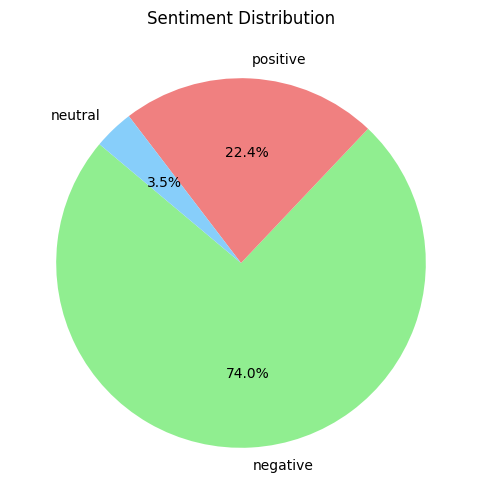

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
colors = ['lightgreen', 'lightcoral', 'lightskyblue']
sentiment_props.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    ylabel='',
    title='Sentiment Distribution'
)
plt.show()


In [ ]:
positive_reviews = df[df['sentiment'] == 'positive']['text_content']
negative_reviews = df[df['sentiment'] == 'negative']['text_content']


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|[^a-zA-Z ]", "", text)  # hapus URL, simbol
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

positive_clean = positive_reviews.apply(clean_text)
negative_clean = negative_reviews.apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


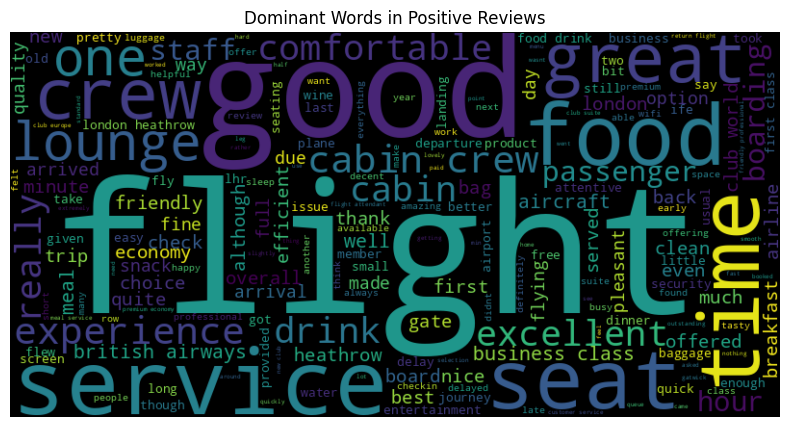

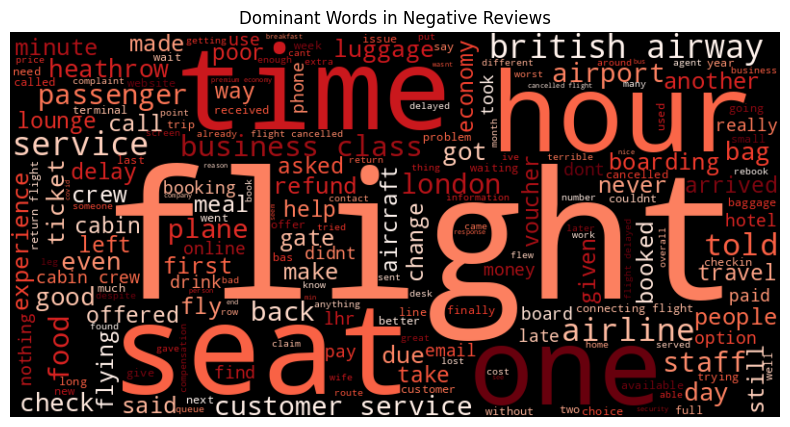

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud positive
wordcloud_pos = WordCloud(width=800, height=400).generate(" ".join(positive_clean))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Dominant Words in Positive Reviews")
plt.axis("off")
plt.show()

# WordCloud negative
wordcloud_neg = WordCloud(width=800, height=400, colormap="Reds").generate(" ".join(negative_clean))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Dominant Words in Negative Reviews")
plt.axis("off")
plt.show()
